## Installation & Setup

Install required libraries for embeddings generation and vector database operations.

In [1]:
# Install required packages for embeddings generation and vector database
%pip install chromadb sentence-transformers pillow pandas numpy tqdm matplotlib seaborn
%pip install datasets torch torchvision

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached opentelemetry_api-1.35.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached PyPika-0.48.9-py2.py3-none-any.whl
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached bcrypt-4.3.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached mmh3-5.1.0-cp312-cp312-win_amd64.whl.metadata (16 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jsonschema-4.25.0-py3-none-any.whl.metadata (7.7 kB


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from typing import List, Dict, Any, Optional
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Vector database and embeddings
import chromadb
from chromadb.config import Settings
from chromadb.utils import embedding_functions

# Machine learning and embeddings
from sentence_transformers import SentenceTransformer
import torch

# Visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns

print(" All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

 All libraries imported successfully!
PyTorch version: 2.7.1+cu126
CUDA available: True
Device: cuda


##  Load Fine-tuned Fashion CLIP Model

Load the fine-tuned CLIP model trained specifically for fashion products from the previous notebook.

In [4]:
# Configuration for model loading
MODEL_OPTIONS = {
    "fine_tuned_local": "models/clip-fashion-product-embeddings",  # Local fine-tuned model
    "fine_tuned_hf": "dejasi5459/clip-fashion-embeddings-final-10k-ft",  # HuggingFace fine-tuned
    "base_clip": "sentence-transformers/clip-ViT-L-14"  # Base CLIP model (fallback)
}

def load_fashion_model(model_preference: str = "fine_tuned_hf") -> SentenceTransformer:
    """
    Load the fashion CLIP model with fallback options.
    
    Args:
        model_preference: Which model to try loading first
    
    Returns:
        SentenceTransformer: Loaded model ready for inference
    """
    print(f"Attempting to load model: {model_preference}")
    
    # Try loading preferred model first
    if model_preference in MODEL_OPTIONS:
        model_path = MODEL_OPTIONS[model_preference]
        try:
            print(f"Loading {model_preference} from: {model_path}")
            model = SentenceTransformer(model_path)
            print(f"Successfully loaded {model_preference}")
            return model
        except Exception as e:
            print(f"Failed to load {model_preference}: {e}")
    
    # Fallback to base CLIP model
    print("Falling back to base CLIP model...")
    try:
        model = SentenceTransformer(MODEL_OPTIONS["base_clip"])
        print("Successfully loaded base CLIP model")
        print("Note: Using base model. For best results, use the fine-tuned fashion model.")
        return model
    except Exception as e:
        print(f" Failed to load any model: {e}")
        raise e

# Load the model (try fine-tuned first, fallback to base)
model = load_fashion_model("fine_tuned_hf")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will run on: {device}")
print(f"Model embedding dimension: {model.get_sentence_embedding_dimension()}")

Attempting to load model: fine_tuned_hf
Loading fine_tuned_hf from: dejasi5459/clip-fashion-embeddings-final-10k-ft


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Successfully loaded fine_tuned_hf
Model will run on: cuda
Model embedding dimension: None


##  Load Fashion Dataset

Load the fashion product dataset with images and metadata for embedding generation.

In [5]:
# Dataset configuration
DATASET_CONFIG = {
    "csv_path": "fashion-product-images-small/styles.csv",
    "images_dir": "fashion-product-images-small/images",
    "sample_size": None,  # Set to number for testing, None for full dataset
}

def load_fashion_dataset(config: Dict[str, Any]) -> pd.DataFrame:
    """
    Load fashion dataset with validation and preprocessing.
    
    Args:
        config: Dataset configuration dictionary
    
    Returns:
        pd.DataFrame: Processed fashion dataset
    """
    print("Loading fashion dataset...")
    
    # Load CSV data
    try:
        df = pd.read_csv(config["csv_path"], on_bad_lines='warn')
        print(f"Loaded {len(df)} products from CSV")
    except FileNotFoundError:
        print(f"Dataset not found at: {config['csv_path']}")
        print("Please ensure the fashion dataset is in the correct location")
        raise
    
    # Add image paths
    df["image_path"] = df["id"].apply(
        lambda x: os.path.join(config["images_dir"], f"{x}.jpg")
    )
    
    # Validate image files exist
    existing_images = []
    missing_count = 0
    
    print("Validating image files...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking images"):
        if os.path.exists(row["image_path"]):
            existing_images.append(idx)
        else:
            missing_count += 1
    
    # Filter to only products with existing images
    df_valid = df.iloc[existing_images].copy()
    
    print(f"Found {len(df_valid)} products with valid images")
    print(f"Missing images: {missing_count}")
    
    # Sample dataset if specified
    if config["sample_size"] and config["sample_size"] < len(df_valid):
        df_valid = df_valid.sample(n=config["sample_size"], random_state=42)
        print(f" Sampled {len(df_valid)} products for processing")
    
    # Create product descriptions for embedding
    df_valid["description"] = df_valid.apply(create_product_description, axis=1)
    
    return df_valid

def create_product_description(row: pd.Series) -> str:
    """
    Create a rich product description for embedding generation.
    
    Args:
        row: Product data row
    
    Returns:
        str: Formatted product description
    """
    components = [
        f"{row['productDisplayName']}",
        f"Gender: {row['gender']}",
        f"Category: {row['masterCategory']} - {row['subCategory']}",
        f"Type: {row['articleType']}",
        f"Color: {row['baseColour']}",
        f"Season: {row['season']}",
        f"Usage: {row['usage']}"
    ]
    
    # Add year if available
    if pd.notna(row['year']):
        components.append(f"Year: {int(row['year'])}")
    
    return " | ".join(components)

# Load the dataset
fashion_df = load_fashion_dataset(DATASET_CONFIG)

# Display dataset info
print("\nDataset Overview:")
print(f"Total products: {len(fashion_df)}")
print(f"Columns: {list(fashion_df.columns)}")
print("\n Sample products:")
print(fashion_df[['id', 'productDisplayName', 'gender', 'masterCategory', 'articleType']].head())

Loading fashion dataset...
Loaded 44424 products from CSV
Validating image files...


Checking images:   1%|          | 354/44424 [00:00<00:24, 1784.25it/s]

Checking images: 100%|██████████| 44424/44424 [00:10<00:00, 4346.94it/s]


Found 44419 products with valid images
Missing images: 5

Dataset Overview:
Total products: 44419
Columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image_path', 'description']

 Sample products:
      id                             productDisplayName gender masterCategory  \
0  15970               Turtle Check Men Navy Blue Shirt    Men        Apparel   
1  39386             Peter England Men Party Blue Jeans    Men        Apparel   
2  59263                       Titan Women Silver Watch  Women    Accessories   
3  21379  Manchester United Men Solid Black Track Pants    Men        Apparel   
4  53759                          Puma Men Grey T-shirt    Men        Apparel   

   articleType  
0       Shirts  
1        Jeans  
2      Watches  
3  Track Pants  
4      Tshirts  


In [6]:
def simulate_prices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Simulate realistic pricing data for fashion products based on category and type.
    
    Args:
        df: Fashion dataset DataFrame
    
    Returns:
        pd.DataFrame: Dataset with simulated prices
    """
    print("Simulating realistic fashion product prices...")
    
    # Price ranges by category and type (in INR)
    price_ranges = {
        ("Apparel", "Topwear"): (500, 3000),
        ("Apparel", "Bottomwear"): (800, 4000),
        ("Footwear", "Shoes"): (1000, 8000),
        ("Footwear", "Sandal"): (300, 2500),
        ("Footwear", "Flip Flops"): (200, 1000),
        ("Accessories", "Watches"): (1500, 15000),
        ("Accessories", "Bags"): (500, 5000),
        ("Accessories", "Belts"): (200, 1500),
        ("Personal Care", "Fragrance"): (300, 2000),
    }
    
    # Default price range
    default_range = (300, 2000)
    
    def get_price(row):
        # Get price range based on category
        key = (row["masterCategory"], row["subCategory"])
        price_range = price_ranges.get(key, default_range)
        
        # Add some randomness and round to nearest 50
        base_price = np.random.uniform(price_range[0], price_range[1])
        
        # Adjust for brand/usage type
        if "Premium" in str(row["productDisplayName"]) or row["usage"] == "Formal":
            base_price *= 1.3
        elif row["usage"] == "Sports":
            base_price *= 1.2
        
        # Round to nearest 50
        return int(round(base_price / 50) * 50)
    
    df_priced = df.copy()
    np.random.seed(42)  # For reproducible prices
    df_priced["price"] = df_priced.apply(get_price, axis=1)
    
    print(f" Added simulated prices (₹{df_priced['price'].min()}-₹{df_priced['price'].max()})")
    
    return df_priced

# Add simulated prices
fashion_df = simulate_prices(fashion_df)

# Display price distribution
print("\n Price Distribution:")
print(f"Min: ₹{fashion_df['price'].min()}")
print(f"Max: ₹{fashion_df['price'].max()}")
print(f"Mean: ₹{fashion_df['price'].mean():.0f}")
print(f"Median: ₹{fashion_df['price'].median():.0f}")

# Show price by category
print("\n Average price by category:")
price_by_category = fashion_df.groupby("masterCategory")["price"].mean().sort_values(ascending=False)
for category, avg_price in price_by_category.head().items():
    print(f"  {category}: ₹{avg_price:.0f}")

Simulating realistic fashion product prices...
 Added simulated prices (₹200-₹18950)

 Price Distribution:
Min: ₹200
Max: ₹18950
Mean: ₹2585
Median: ₹1800

 Average price by category:
  Footwear: ₹4062
  Accessories: ₹3181
  Apparel: ₹1803
  Sporting Goods: ₹1486
  Personal Care: ₹1149


##  Initialize ChromaDB Vector Database

Set up ChromaDB to store multi-modal embeddings with rich metadata for efficient fashion product retrieval.

In [7]:
# ChromaDB configuration
CHROMA_CONFIG = {
    "persist_directory": "./fashion_vector_db",
    "collection_name": "fashion_products",
    "embedding_dimension": model.get_sentence_embedding_dimension()
}

def initialize_chromadb(config: Dict[str, Any], reset: bool = False) -> chromadb.Collection:
    """
    Initialize ChromaDB client and collection for fashion products.
    
    Args:
        config: ChromaDB configuration
        reset: Whether to reset existing collection
    
    Returns:
        chromadb.Collection: Initialized collection
    """
    print(" Initializing ChromaDB vector database...")
    
    # Create persistent client
    client = chromadb.PersistentClient(
        path=config["persist_directory"],
        settings=Settings(
            anonymized_telemetry=False,
            allow_reset=True
        )
    )
    
    print(f"Database location: {config['persist_directory']}")
    
    # Reset collection if requested
    if reset:
        try:
            client.delete_collection(config["collection_name"])
            print("Existing collection reset")
        except Exception:
            pass  # Collection doesn't exist
    
    # Create or get collection
    try:
        collection = client.get_collection(config["collection_name"])
        existing_count = collection.count()
        print(f"Connected to existing collection with {existing_count} items")
    except Exception:  # Changed from ValueError to Exception to catch NotFoundError
        # Collection doesn't exist, create new one
        collection = client.create_collection(
            name=config["collection_name"],
            metadata={
                "description": "Fashion product multi-modal embeddings",
                "embedding_dimension": str(config["embedding_dimension"]),
                "created_by": "fashion_recommendation_engine"
            }
        )
        print(f"Created new collection: {config['collection_name']}")
    
    return collection

# Initialize ChromaDB
chroma_collection = initialize_chromadb(CHROMA_CONFIG, reset=False)

print(f"\nCollection Info:")
print(f"Name: {chroma_collection.name}")
print(f"Count: {chroma_collection.count()}")
print(f"Embedding dimension: {CHROMA_CONFIG['embedding_dimension']}")

 Initializing ChromaDB vector database...
Database location: ./fashion_vector_db
Created new collection: fashion_products

Collection Info:
Name: fashion_products
Count: 0
Embedding dimension: None


## Generate Multi-Modal Embeddings

Generate embeddings for both product images and text descriptions using the fine-tuned CLIP model.

In [8]:
# Embedding generation configuration
EMBEDDING_CONFIG = {
    "batch_size": 32,
    "text_batch_size": 64,
    "image_batch_size": 16,
    "show_progress": True
}

def generate_text_embeddings(
    texts: List[str], 
    model: SentenceTransformer, 
    batch_size: int = 64
) -> np.ndarray:
    """
    Generate embeddings for product text descriptions.
    
    Args:
        texts: List of product descriptions
        model: Trained SentenceTransformer model
        batch_size: Batch size for processing
    
    Returns:
        np.ndarray: Text embeddings array
    """
    print(f" Generating text embeddings for {len(texts)} products...")
    
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # L2 normalize for better similarity search
    )
    
    print(f" Generated text embeddings: {embeddings.shape}")
    return embeddings

def generate_image_embeddings(
    image_paths: List[str], 
    model: SentenceTransformer, 
    batch_size: int = 16
) -> np.ndarray:
    """
    Generate embeddings for product images.
    
    Args:
        image_paths: List of image file paths
        model: Trained SentenceTransformer model
        batch_size: Batch size for processing
    
    Returns:
        np.ndarray: Image embeddings array
    """
    print(f"Generating image embeddings for {len(image_paths)} products...")
    
    # Load and process images
    images = []
    failed_images = []
    
    for i, path in enumerate(tqdm(image_paths, desc="Loading images")):
        try:
            img = Image.open(path).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"Failed to load image {path}: {e}")
            # Create a black placeholder image
            images.append(Image.new("RGB", (224, 224), color="black"))
            failed_images.append(i)
    
    if failed_images:
        print(f"{len(failed_images)} images failed to load, using placeholders")
    
    # Generate embeddings
    embeddings = model.encode(
        images,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # L2 normalize for better similarity search
    )
    
    print(f"Generated image embeddings: {embeddings.shape}")
    return embeddings

def prepare_metadata(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Prepare metadata for each product for ChromaDB storage.
    
    Args:
        df: Fashion dataset DataFrame
    
    Returns:
        List[Dict]: Metadata dictionaries for each product
    """
    print("Preparing metadata for ChromaDB storage...")
    
    metadata_list = []
    
    for _, row in df.iterrows():
        metadata = {
            "product_id": str(row["id"]),
            "product_name": str(row["productDisplayName"]),
            "gender": str(row["gender"]),
            "master_category": str(row["masterCategory"]),
            "sub_category": str(row["subCategory"]),
            "article_type": str(row["articleType"]),
            "base_colour": str(row["baseColour"]),
            "season": str(row["season"]),
            "usage": str(row["usage"]),
            "price": float(row["price"]),
            "image_path": str(row["image_path"]),
            "description": str(row["description"])
        }
        
        # Add year if available
        if pd.notna(row["year"]):
            metadata["year"] = int(row["year"])
        
        metadata_list.append(metadata)
    
    print(f"Prepared metadata for {len(metadata_list)} products")
    return metadata_list

# Generate embeddings (this might take a while for large datasets)
print("Starting embedding generation process...")

# Generate text embeddings
text_embeddings = generate_text_embeddings(
    fashion_df["description"].tolist(),
    model,
    EMBEDDING_CONFIG["text_batch_size"]
)

# Generate image embeddings  
image_embeddings = generate_image_embeddings(
    fashion_df["image_path"].tolist(),
    model,
    EMBEDDING_CONFIG["image_batch_size"]
)

# Prepare metadata
metadata_list = prepare_metadata(fashion_df)

print(f"\nEmbedding Generation Summary:")
print(f"Products processed: {len(fashion_df)}")
print(f"Text embeddings: {text_embeddings.shape}")
print(f"Image embeddings: {image_embeddings.shape}")
print(f"Metadata entries: {len(metadata_list)}")

Starting embedding generation process...
 Generating text embeddings for 44419 products...


Batches: 100%|██████████| 695/695 [01:47<00:00,  6.47it/s]


 Generated text embeddings: (44419, 768)
Generating image embeddings for 44419 products...


Batches: 100%|██████████| 2777/2777 [36:26<00:00,  1.27it/s]


Generated image embeddings: (44419, 768)
Preparing metadata for ChromaDB storage...
Prepared metadata for 44419 products

Embedding Generation Summary:
Products processed: 44419
Text embeddings: (44419, 768)
Image embeddings: (44419, 768)
Metadata entries: 44419


## Store Embeddings in ChromaDB

Store both text and image embeddings in ChromaDB with rich metadata for efficient retrieval and filtering.

In [9]:
def store_embeddings_in_chromadb(
    collection: chromadb.Collection,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    metadata_list: List[Dict[str, Any]],
    batch_size: int = 100
) -> None:
    """
    Store embeddings and metadata in ChromaDB collection.
    
    Args:
        collection: ChromaDB collection
        text_embeddings: Text embeddings array
        image_embeddings: Image embeddings array
        metadata_list: List of metadata dictionaries
        batch_size: Batch size for storage
    """
    print("Storing embeddings in ChromaDB...")
    
    n_products = len(metadata_list)
    
    # Process in batches to avoid memory issues
    for i in tqdm(range(0, n_products, batch_size), desc="Storing batches"):
        end_idx = min(i + batch_size, n_products)
        batch_metadata = metadata_list[i:end_idx]
        
        # Create unique IDs for text and image embeddings
        text_ids = [f"text_{meta['product_id']}" for meta in batch_metadata]
        image_ids = [f"image_{meta['product_id']}" for meta in batch_metadata]
        
        # Prepare metadata with type indicators
        text_metadata = [{**meta, "embedding_type": "text"} for meta in batch_metadata]
        image_metadata = [{**meta, "embedding_type": "image"} for meta in batch_metadata]
        
        # Store text embeddings
        collection.add(
            ids=text_ids,
            embeddings=text_embeddings[i:end_idx].tolist(),
            metadatas=text_metadata,
            documents=[meta["description"] for meta in batch_metadata]
        )
        
        # Store image embeddings
        collection.add(
            ids=image_ids,
            embeddings=image_embeddings[i:end_idx].tolist(),
            metadatas=image_metadata,
            documents=[f"Image: {meta['product_name']}" for meta in batch_metadata]
        )
    
    print(f"Successfully stored {n_products * 2} embeddings ({n_products} text + {n_products} image)")

# Check if embeddings already exist
existing_count = chroma_collection.count()
expected_count = len(fashion_df) * 2  # Text + Image embeddings

if existing_count == expected_count:
    print(f"Embeddings already exist in collection ({existing_count} items)")
    print("Skipping storage. Set reset=True in ChromaDB init to recreate.")
else:
    # Store embeddings
    store_embeddings_in_chromadb(
        chroma_collection,
        text_embeddings,
        image_embeddings,
        metadata_list,
        batch_size=100
    )

# Verify storage
final_count = chroma_collection.count()
print(f"\nChromaDB Storage Summary:")
print(f"Total embeddings stored: {final_count}")
print(f"Products with embeddings: {final_count // 2}")
print(f"Embedding types: Text and Image for each product")

Storing embeddings in ChromaDB...


Storing batches: 100%|██████████| 445/445 [03:42<00:00,  2.00it/s]

Successfully stored 88838 embeddings (44419 text + 44419 image)

ChromaDB Storage Summary:
Total embeddings stored: 88838
Products with embeddings: 44419
Embedding types: Text and Image for each product


## Fashion Product Search & Retrieval

Create search functions to query the vector database for fashion recommendations.

In [14]:
class FashionProductSearcher:
    """
    Advanced search interface for fashion product recommendations.
    """
    
    def __init__(self, collection: chromadb.Collection, model: SentenceTransformer):
        self.collection = collection
        self.model = model
        
    def search_by_text(
        self, 
        query: str, 
        n_results: int = 10,
        filters: Optional[Dict[str, Any]] = None,
        search_both_types: bool = True
    ) -> Dict[str, Any]:
        """
        Search for fashion products using text query.
        
        Args:
            query: Natural language search query
            n_results: Number of results to return
            filters: Metadata filters (gender, category, price_range, etc.)
            search_both_types: Whether to search both text and image embeddings
        
        Returns:
            Dict containing search results and metadata
        """
        print(f"Searching for: '{query}'")
        
        # Generate query embedding
        query_embedding = self.model.encode([query], normalize_embeddings=True)
        
        # Prepare where clause for filtering
        where_clause = None
        if filters:
            conditions = []
            if "gender" in filters:
                conditions.append({"gender": {"$eq": filters["gender"]}})
            if "master_category" in filters:
                conditions.append({"master_category": {"$eq": filters["master_category"]}})
            if "usage" in filters:
                conditions.append({"usage": {"$eq": filters["usage"]}})
            
            # ChromaDB requires at least 2 conditions for $and operator
            if len(conditions) > 1:
                where_clause = {"$and": conditions}
            elif len(conditions) == 1:
                where_clause = conditions[0]

            # Note: ChromaDB doesn't support range queries directly on metadata yet.
            # Price filtering will be done post-query.
        
        # Search embeddings
        results = self.collection.query(
            query_embeddings=query_embedding.tolist(),
            n_results=n_results * 2 if search_both_types else n_results,
            where=where_clause,
            include=["metadatas", "documents", "distances"]
        )
        
        # Process and filter results
        processed_results = self._process_search_results(results, filters)
        
        return {
            "query": query,
            "filters": filters,
            "results": processed_results[:n_results],
            "total_found": len(processed_results)
        }
    
    def search_by_image(
        self,
        image_path: str,
        n_results: int = 10,
        filters: Optional[Dict[str, Any]] = None
    ) -> Dict[str, Any]:
        """
        Search for similar fashion products using an image.
        
        Args:
            image_path: Path to query image
            n_results: Number of results to return
            filters: Metadata filters
        
        Returns:
            Dict containing search results and metadata
        """
        print(f"Searching by image: {image_path}")
        
        try:
            # Load and encode query image
            query_image = Image.open(image_path).convert("RGB")
            query_embedding = self.model.encode([query_image], normalize_embeddings=True)
            
            # Search primarily in image embeddings
            results = self.collection.query(
                query_embeddings=query_embedding.tolist(),
                n_results=n_results * 2,  # Get extra to filter
                where={"embedding_type": "image"},
                include=["metadatas", "documents", "distances"]
            )
            
            # Process results
            processed_results = self._process_search_results(results, filters)
            
            return {
                "query_image": image_path,
                "filters": filters,
                "results": processed_results[:n_results],
                "total_found": len(processed_results)
            }
            
        except Exception as e:
            print(f" Error searching by image: {e}")
            return {"error": str(e)}
    
    def _process_search_results(
        self, 
        results: Dict[str, Any], 
        filters: Optional[Dict[str, Any]] = None
    ) -> List[Dict[str, Any]]:
        """
        Process and filter search results.
        
        Args:
            results: Raw ChromaDB search results
            filters: Additional filters to apply
        
        Returns:
            List of processed results
        """
        processed = []
        
        for i, metadata in enumerate(results["metadatas"][0]):
            result = {
                "product_id": metadata["product_id"],
                "product_name": metadata["product_name"],
                "gender": metadata["gender"],
                "category": f"{metadata['master_category']} - {metadata['sub_category']}",
                "type": metadata["article_type"],
                "color": metadata["base_colour"],
                "price": metadata["price"],
                "season": metadata["season"],
                "usage": metadata["usage"],
                "similarity": 1 - results["distances"][0][i],  # Convert distance to similarity
                "embedding_type": metadata["embedding_type"],
                "description": metadata["description"]
            }
            
            # Apply price filter if specified
            if filters and "price_range" in filters:
                min_price, max_price = filters["price_range"]
                if not (min_price <= result["price"] <= max_price):
                    continue
            
            processed.append(result)
        
        # Sort by similarity (highest first)
        processed.sort(key=lambda x: x["similarity"], reverse=True)
        
        return processed

# Initialize searcher
searcher = FashionProductSearcher(chroma_collection, model)
print("Fashion Product Searcher initialized!")

Fashion Product Searcher initialized!


## demo: Fashion Product Search Examples

Test the vector database with various search queries to demonstrate functionality.

In [15]:
def display_search_results(results: Dict[str, Any], max_display: int = 5):
    """
    Display search results in a formatted way.
    
    Args:
        results: Search results from searcher
        max_display: Maximum number of results to display
    """
    if "error" in results:
        print(f"Search error: {results['error']}")
        return
    
    print(f"\nQuery: {results.get('query', results.get('query_image', 'Unknown'))}")
    if results.get('filters'):
        print(f" Filters: {results['filters']}")
    print(f"Found {results['total_found']} results\n")
    
    for i, result in enumerate(results['results'][:max_display]):
        print(f"#{i+1} - {result['product_name']}")
        print(f"   {result['gender']} | {result['category']}")
        print(f"    {result['color']} | ₹{result['price']}")
        print(f"    Similarity: {result['similarity']:.3f} | {result['embedding_type']}")
        print()

# Example 1: General fashion search
print(" Example 1: General Fashion Search")
results1 = searcher.search_by_text(
    query="casual blue jeans for men",
    n_results=5
)
display_search_results(results1)

# Example 2: Filtered search by gender and category
print(" Example 2: Filtered Search")
results2 = searcher.search_by_text(
    query="formal shirt",
    n_results=5,
    filters={
        "gender": "Men",
        "master_category": "Apparel"
    }
)
display_search_results(results2)

# Example 3: Search with price filter
print(" Example 3: Price-Filtered Search")
results3 = searcher.search_by_text(
    query="summer dress women",
    n_results=5,
    filters={
        "gender": "Women",
        "price_range": (500, 2000)
    }
)
display_search_results(results3)

 Example 1: General Fashion Search
Searching for: 'casual blue jeans for men'

Query: casual blue jeans for men
Found 10 results

#1 - Levis Men Blue Jeans
   Men | Apparel - Bottomwear
    Blue | ₹900.0
    Similarity: 0.023 | text

#2 - Lee Men Blue Party Jeans
   Men | Apparel - Bottomwear
    Blue | ₹1850.0
    Similarity: 0.016 | text

#3 - Wrangler Men Blue Texas Jeans
   Men | Apparel - Bottomwear
    Blue | ₹1350.0
    Similarity: -0.008 | text

#4 - Wrangler Men Blue Texas Jeans
   Men | Apparel - Bottomwear
    Blue | ₹1000.0
    Similarity: -0.008 | text

#5 - Wrangler Men Blue Texas Jeans
   Men | Apparel - Bottomwear
    Blue | ₹2300.0
    Similarity: -0.008 | text

 Example 2: Filtered Search
Searching for: 'formal shirt'

Query: formal shirt
 Filters: {'gender': 'Men', 'master_category': 'Apparel'}
Found 10 results

#1 - John Miller Men Striped White Shirt
   Men | Apparel - Topwear
    White | ₹3350.0
    Similarity: -0.348 | image

#2 - John Miller Men Striped White Sh

In [16]:
# Example 4: Image-based search (if you have a sample image)
print(" Example 4: Image-based Search")

# Try to find a sample image from the dataset
sample_image_path = fashion_df.iloc[0]["image_path"]

if os.path.exists(sample_image_path):
    print(f"Using sample image: {sample_image_path}")
    results4 = searcher.search_by_image(
        image_path=sample_image_path,
        n_results=5,
        filters={"gender": "Men"}
    )
    display_search_results(results4)
else:
    print(f" Sample image not found: {sample_image_path}")
    print(" You can test image search by providing a valid image path")

 Example 4: Image-based Search
Using sample image: fashion-product-images-small/images\15970.jpg
Searching by image: fashion-product-images-small/images\15970.jpg

Query: fashion-product-images-small/images\15970.jpg
 Filters: {'gender': 'Men'}
Found 10 results

#1 - Turtle Check Men Navy Blue Shirt
   Men | Apparel - Topwear
    Navy Blue | ₹1450.0
    Similarity: 1.000 | image

#2 - Indigo Nation Men Checks Shirt Navy Blue Shirts
   Men | Apparel - Topwear
    Navy Blue | ₹2700.0
    Similarity: 0.845 | image

#3 - Indigo Nation Men Checks Shirt Navy Blue Shirts
   Men | Apparel - Topwear
    Navy Blue | ₹800.0
    Similarity: 0.845 | image

#4 - United Colors of Benetton Men Check Blue Shirt
   Men | Apparel - Topwear
    Blue | ₹950.0
    Similarity: 0.803 | image

#5 - Highlander Men Check Blue Shirt
   Men | Apparel - Topwear
    Blue | ₹1800.0
    Similarity: 0.801 | image


Query: fashion-product-images-small/images\15970.jpg
 Filters: {'gender': 'Men'}
Found 10 results

#1 - T

##  Vector Database Analytics & Visualization

Analyze the embeddings and visualize the fashion product distribution in the vector space.

Analyzing vector database...
 Vector Database Analysis Results:
Total embeddings: 88838
Unique products: 44419
Embedding types: {'text': 44419, 'image': 44419}

Gender Distribution:
  Men: 44284
  Women: 37262
  Unisex: 4322
  Boys: 1660
  Girls: 1310

 Category Distribution:
  Apparel: 42784
  Accessories: 22548
  Footwear: 18438
  Personal Care: 4806
  Free Items: 210

 Price Statistics:
  Range: ₹200 - ₹18950
  Average: ₹2585
  Median: ₹1800
 Vector Database Analysis Results:
Total embeddings: 88838
Unique products: 44419
Embedding types: {'text': 44419, 'image': 44419}

Gender Distribution:
  Men: 44284
  Women: 37262
  Unisex: 4322
  Boys: 1660
  Girls: 1310

 Category Distribution:
  Apparel: 42784
  Accessories: 22548
  Footwear: 18438
  Personal Care: 4806
  Free Items: 210

 Price Statistics:
  Range: ₹200 - ₹18950
  Average: ₹2585
  Median: ₹1800


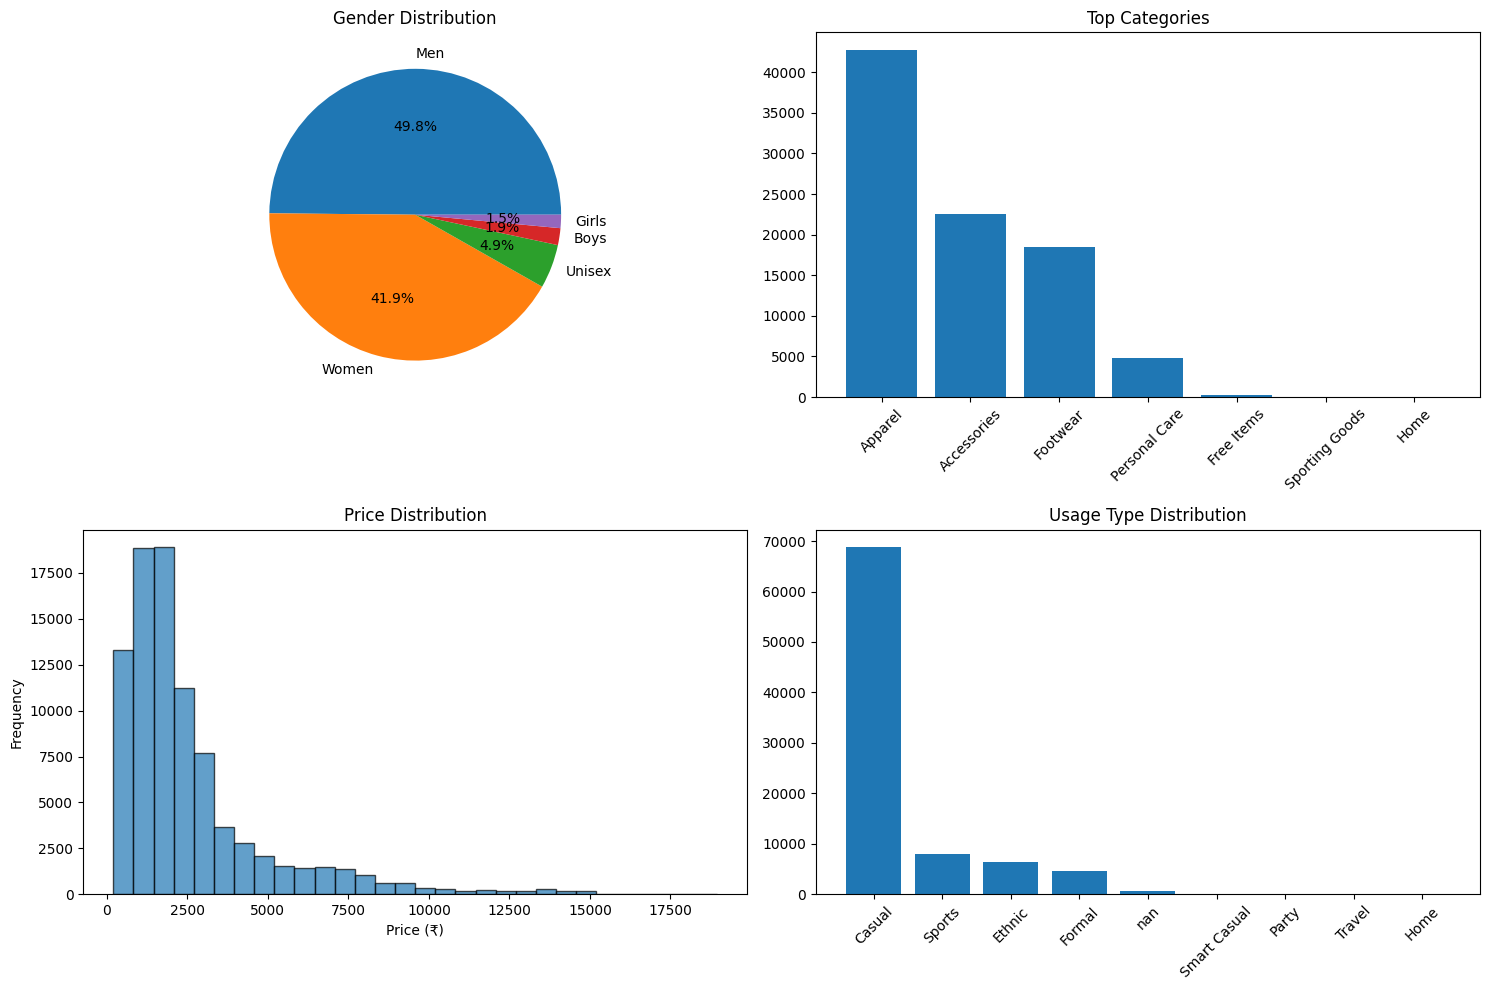

\ Vector database analysis complete!


In [17]:
def analyze_vector_database(collection: chromadb.Collection) -> Dict[str, Any]:
    """
    Analyze the vector database to provide insights about the stored embeddings.
    
    Args:
        collection: ChromaDB collection to analyze
    
    Returns:
        Dict containing analysis results
    """
    print("Analyzing vector database...")
    
    # Get all metadata for analysis
    all_results = collection.get(include=["metadatas"])
    metadata_list = all_results["metadatas"]
    
    # Convert to DataFrame for easier analysis
    df_meta = pd.DataFrame(metadata_list)
    
    analysis = {
        "total_embeddings": len(metadata_list),
        "unique_products": len(df_meta["product_id"].unique()),
        "embedding_types": df_meta["embedding_type"].value_counts().to_dict(),
        "gender_distribution": df_meta["gender"].value_counts().to_dict(),
        "category_distribution": df_meta["master_category"].value_counts().to_dict(),
        "price_stats": {
            "min": df_meta["price"].min(),
            "max": df_meta["price"].max(),
            "mean": df_meta["price"].mean(),
            "median": df_meta["price"].median()
        }
    }
    
    return analysis, df_meta

# Perform analysis
analysis_results, metadata_df = analyze_vector_database(chroma_collection)

# Display results
print(" Vector Database Analysis Results:")
print("=" * 50)
print(f"Total embeddings: {analysis_results['total_embeddings']}")
print(f"Unique products: {analysis_results['unique_products']}")
print(f"Embedding types: {analysis_results['embedding_types']}")

print(f"\nGender Distribution:")
for gender, count in analysis_results['gender_distribution'].items():
    print(f"  {gender}: {count}")

print(f"\n Category Distribution:")
for category, count in list(analysis_results['category_distribution'].items())[:5]:
    print(f"  {category}: {count}")

print(f"\n Price Statistics:")
price_stats = analysis_results['price_stats']
print(f"  Range: ₹{price_stats['min']:.0f} - ₹{price_stats['max']:.0f}")
print(f"  Average: ₹{price_stats['mean']:.0f}")
print(f"  Median: ₹{price_stats['median']:.0f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gender distribution
gender_counts = metadata_df['gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Gender Distribution')

# Category distribution (top 8)
category_counts = metadata_df['master_category'].value_counts().head(8)
axes[0, 1].bar(category_counts.index, category_counts.values)
axes[0, 1].set_title('Top Categories')
axes[0, 1].tick_params(axis='x', rotation=45)

# Price distribution
axes[1, 0].hist(metadata_df['price'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Price Distribution')
axes[1, 0].set_xlabel('Price (₹)')
axes[1, 0].set_ylabel('Frequency')

# Usage distribution
usage_counts = metadata_df['usage'].value_counts()
axes[1, 1].bar(usage_counts.index, usage_counts.values)
axes[1, 1].set_title('Usage Type Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\ Vector database analysis complete!")

##  Prepare for RAG System Integration

Set up utilities and export functions to integrate with LangChain-powered RAG system for natural language fashion queries.

In [18]:
class FashionRAGRetriever:
    """
    Retriever class for LangChain RAG integration.
    Provides formatted product information for fashion recommendations.
    """
    
    def __init__(self, searcher: FashionProductSearcher):
        self.searcher = searcher
    
    def get_relevant_products(
        self,
        query: str,
        n_results: int = 5,
        filters: Optional[Dict[str, Any]] = None
    ) -> List[Dict[str, Any]]:
        """
        Get relevant products for RAG context injection.
        
        Args:
            query: Natural language query
            n_results: Number of products to retrieve
            filters: Metadata filters
        
        Returns:
            List of formatted product information for LLM context
        """
        # Search for relevant products
        search_results = self.searcher.search_by_text(
            query=query,
            n_results=n_results,
            filters=filters
        )
        
        # Format for RAG context
        formatted_products = []
        for result in search_results["results"]:
            product_info = {
                "id": result["product_id"],
                "name": result["product_name"],
                "category": result["category"],
                "gender": result["gender"],
                "color": result["color"],
                "price": f"₹{result['price']}",
                "season": result["season"],
                "usage": result["usage"],
                "description": result["description"],
                "relevance_score": f"{result['similarity']:.3f}"
            }
            formatted_products.append(product_info)
        
        return formatted_products
    
    def format_for_prompt(self, products: List[Dict[str, Any]]) -> str:
        """
        Format product information for LLM prompt injection.
        
        Args:
            products: List of product dictionaries
        
        Returns:
            Formatted string for prompt context
        """
        if not products:
            return "No relevant products found."
        
        context = "AVAILABLE FASHION PRODUCTS:\n\n"
        
        for i, product in enumerate(products, 1):
            context += f"{i}. {product['name']}\n"
            context += f"   • Category: {product['category']}\n"
            context += f"   • Gender: {product['gender']}\n"
            context += f"   • Color: {product['color']}\n"
            context += f"   • Price: {product['price']}\n"
            context += f"   • Season: {product['season']}\n"
            context += f"   • Usage: {product['usage']}\n"
            context += f"   • Relevance: {product['relevance_score']}\n\n"
        
        return context

# Initialize RAG retriever
rag_retriever = FashionRAGRetriever(searcher)

print(" RAG Retriever initialized for LangChain integration!")

# Example: RAG context preparation
print("\n Example RAG Context Generation:")
query = "What should I wear for a casual summer date?"
products = rag_retriever.get_relevant_products(query, n_results=3)
context = rag_retriever.format_for_prompt(products)

print(f"Query: {query}")
print("Generated Context:")
print("=" * 50)
print(context)

 RAG Retriever initialized for LangChain integration!

 Example RAG Context Generation:
Searching for: 'What should I wear for a casual summer date?'
Query: What should I wear for a casual summer date?
Generated Context:
AVAILABLE FASHION PRODUCTS:

1. Myntra Men Yellow Check Shorts
   • Category: Apparel - Bottomwear
   • Gender: Men
   • Color: Yellow
   • Price: ₹2600.0
   • Season: Summer
   • Usage: Casual
   • Relevance: -0.517

2. Wills Lifestyle Men Cream Trousers
   • Category: Apparel - Bottomwear
   • Gender: Men
   • Color: Cream
   • Price: ₹1500.0
   • Season: Summer
   • Usage: Casual
   • Relevance: -0.541

3. Indian Terrain Men Laffer Off-White Trousers
   • Category: Apparel - Bottomwear
   • Gender: Men
   • Color: White
   • Price: ₹1100.0
   • Season: Fall
   • Usage: Formal
   • Relevance: -0.542




## Export & Persistence Utilities

Save embeddings configuration and provide utilities for system integration.

In [19]:
# Export configuration for system integration
def export_system_config() -> Dict[str, Any]:
    """
    Export system configuration for integration with other components.
    
    Returns:
        Configuration dictionary for API/RAG integration
    """
    config = {
        "vector_database": {
            "type": "chromadb",
            "path": CHROMA_CONFIG["persist_directory"],
            "collection_name": CHROMA_CONFIG["collection_name"],
            "embedding_dimension": CHROMA_CONFIG["embedding_dimension"]
        },
        "model": {
            "name": "fashion-clip-embeddings",
            "type": "sentence-transformers",
            "embedding_dimension": model.get_sentence_embedding_dimension(),
            "normalization": "l2"
        },
        "dataset": {
            "total_products": len(fashion_df),
            "has_text_embeddings": True,
            "has_image_embeddings": True,
            "metadata_fields": [
                "product_id", "product_name", "gender", "master_category",
                "sub_category", "article_type", "base_colour", "season",
                "usage", "price", "year"
            ]
        },
        "search_capabilities": {
            "text_search": True,
            "image_search": True,
            "metadata_filtering": True,
            "price_filtering": True,
            "similarity_threshold": 0.5
        }
    }
    return config

# Save configuration
system_config = export_system_config()

# Export to JSON file for other components
config_file = "fashion_system_config.json"
with open(config_file, "w") as f:
    json.dump(system_config, f, indent=2)

print(f" System configuration exported to: {config_file}")

# Display configuration summary
print("\n System Configuration Summary:")
print("=" * 50)
print(f"Vector Database: ChromaDB ({system_config['vector_database']['path']})")
print(f"Collection: {system_config['vector_database']['collection_name']}")
print(f"Total Products: {system_config['dataset']['total_products']}")
print(f"Embedding Dimension: {system_config['model']['embedding_dimension']}")
print(f"Text Embeddings: ok")
print(f"Image Embeddings: ok")
print(f"Metadata Filtering: ok")

# Create utility functions for external access
class FashionEmbeddingSystem:
    """
    Main interface for the fashion embedding system.
    Use this class to integrate with APIs or other components.
    """
    
    def __init__(self):
        self.config = system_config
        self.collection = chroma_collection
        self.model = model
        self.searcher = searcher
        self.rag_retriever = rag_retriever
    
    def health_check(self) -> Dict[str, Any]:
        """Check system health and status."""
        return {
            "status": "healthy",
            "vector_db_count": self.collection.count(),
            "model_loaded": self.model is not None,
            "expected_embeddings": len(fashion_df) * 2,
            "actual_embeddings": self.collection.count()
        }
    
    def search_products(self, query: str, **kwargs) -> Dict[str, Any]:
        """Unified search interface."""
        return self.searcher.search_by_text(query, **kwargs)
    
    def get_rag_context(self, query: str, **kwargs) -> str:
        """Get formatted context for RAG system."""
        products = self.rag_retriever.get_relevant_products(query, **kwargs)
        return self.rag_retriever.format_for_prompt(products)

# Initialize system interface
fashion_system = FashionEmbeddingSystem()

# Test system health
health_status = fashion_system.health_check()
print(f"\n System Health Check:")
print(f"Status: {health_status['status']}")
print(f"Vector DB Count: {health_status['vector_db_count']}")
print(f"Expected Embeddings: {health_status['expected_embeddings']}")
print(f"Actual Embeddings: {health_status['actual_embeddings']}")

if health_status['actual_embeddings'] == health_status['expected_embeddings']:
    print(" All embeddings successfully stored!")
else:
    print("Embedding count mismatch - check storage process")

 System configuration exported to: fashion_system_config.json

 System Configuration Summary:
Vector Database: ChromaDB (./fashion_vector_db)
Collection: fashion_products
Total Products: 44419
Embedding Dimension: None
Text Embeddings: ok
Image Embeddings: ok
Metadata Filtering: ok

 System Health Check:
Status: healthy
Vector DB Count: 88838
Expected Embeddings: 88838
Actual Embeddings: 88838
 All embeddings successfully stored!
